# 案例描述

图像分类，即给定一幅输入图像，通过某种分类算法来判断该图像所属的类别。在日常生活中，图像分类有广泛的应用，例如车牌识别、物体检测等。

随着大数据的到来，基于卷积神经网络的图像分类方法能够处理庞大的图像数据，满足人们对分类精度和速度上的要求，成为目前图像分类的主流算法。

本案例使用VGG16模型训练精灵宝可梦数据集，达到准确率较高的图像分类效果。

# 目录
[1. 数据集简介](#1)<br>
[2. 模型介绍](#2)<br>
[3. 数据预处理](#3)<br>
&nbsp;&nbsp;&nbsp;&nbsp;[3.1 划分数据集](#3.1)<br>
&nbsp;&nbsp;&nbsp;&nbsp;[3.2 类别标签和名称](#3.2)<br>
&nbsp;&nbsp;&nbsp;&nbsp;[3.3 转换图像大小](#3.3)<br>
[4. Pytorch读取数据](#4)<br>
&nbsp;&nbsp;&nbsp;&nbsp;[4.1 ImageFolder](#4.1)<br>
&nbsp;&nbsp;&nbsp;&nbsp;[4.2 torch.utils.data.DataLoader](#4.2)<br>

[5. 构建模型](#5)<br>
[6. 模型训练](#6)<br>
[7. 图像分类效果](#7)<br>
[8. 总结](#8)<br>



<div id="1"></div>
# 1 数据集简介

Pokemon数据集大小为78.9 MB，包含了30类神奇宝贝的图像。每类约包含40-70张图像，其中神奇宝贝的形态各异、颜色各异、身处的环境多样化。每张图像的像素大小不一致，全部为彩色图像。


<div id="2"></div>
# 2 模型介绍

本案例采用VGG16模型，VGG16的结构非常简洁，整个网络使用了同样大小的卷积核尺寸：$3 \times 3$的卷积核和$2 \times 2$的池化核。网络中共包含了16个隐藏层，其中13个为卷积层，3个为全连接层。

在实践中发现，VGG16中几个小滤波器（$3 \times 3$）卷积层的组合比一个大滤波器（$5 \times 5$或$7 \times 7$）卷积层好。且网络验证了，通过不断加深网络结构可以提升模型性能。

下图展示了VGG16模型的网络结构：



<div id="3"></div>
# 3 数据预处理

深度学习模型需要使用已知数据集，不断更新参数，得到一个最优参数，使得模型可以较为准确地对图像进行分类。

在优化模型的过程中，数据集一般分为3个部分：训练集、验证集、测试集。
+ 训练集：代入模型中，最小化损失函数，并通过反向传播等方式，多次迭代不断优化模型参数。

+ 验证集：在使用训练集更新参数后，将验证集放入模型，测试模型分类是否准确。可以依据验证集的分类结果来调整模型超参数。

+ 测试集：使用完全没有经过训练的测试集，测试模型的分类准确率。

在收集数据的过程中，大多数数据集往往仅将图像进行分类，并不会将其进一步划分为训练集、验证集、测试集，如本案例中使用的Pokemon数据集。因此接下来的步骤，介绍如何划分数据集。

首先加载需要使用的库，便于后续调用函数。

In [1]:
%matplotlib inline 
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt
import torch
from torch import nn
from torch import optim
from torchvision import datasets, models, transforms
import torch.nn.functional as F
import torch.utils.data 
import pandas as pd
import numpy as np
from collections import OrderedDict
from PIL import Image
import seaborn as sb
import os
import random
import shutil
from shutil import copy2
import json
import re
import cv2

再调用函数，解压zip文件夹，读取Pokemon数据集。

In [2]:
# 读取压缩为zip文件的数据集
import os
!apt install unzip
!unzip Pokemon.zip

Reading package lists... Done
Building dependency tree       
Reading state information... Done
unzip is already the newest version (6.0-21ubuntu1).
0 upgraded, 0 newly installed, 0 to remove and 14 not upgraded.
Archive:  Pokemon.zip
   creating: Pokemon/
   creating: Pokemon/三地鼠/
  inflating: Pokemon/三地鼠/0378a7655c944cc89222303111f2ee9d.jpg  
  inflating: Pokemon/三地鼠/0c5f972fb2c64e7f8468ef44c98ff3e5.jpg  
  inflating: Pokemon/三地鼠/1061c5378fe842d9b1554a14d75e5857.jpg  
  inflating: Pokemon/三地鼠/12b14467613b475c8236233ac679b6fb.jpg  
  inflating: Pokemon/三地鼠/1453d590837e48df85676e05afa15b3f.jpg  
  inflating: Pokemon/三地鼠/17e1bc42e7e14ef19102d91e5b17cc6a.jpg  
  inflating: Pokemon/三地鼠/22384569dc6c4c74afe1d64c5a06636c.jpg  
  inflating: Pokemon/三地鼠/2240b95d9757417992d8bd0846e2d354.jpg  
  inflating: Pokemon/三地鼠/2567c6428942424496f02d511c3d61b5.jpg  
  inflating: Pokemon/三地鼠/2d5e46eee7f148a7aa176e86e943fb4f.jpg  
  inflating: Pokemon/三地鼠/2f5fc7477fe4452e89ad22df799182c3.jpg  
  inflating: 

<div id="3.1"></div>
## 3.1 划分数据集

编写函数划分数据集。本案例中采用的划分比例为，训练集：验证集：测试集 = 8:1:1。划分数据集的思路为：建立训练集、验证集、测试集目录，及对应的类别目录；随机复制对应数量的图像到各个目录中。

In [3]:
# 设置随机种子，固定数据划分结果
random.seed (2)

def data_set_split(src_data_folder, target_data_folder, train_scale=0.8, val_scale=0.1, test_scale=0.1):
# src_data_folder: 源文件夹; target_data_folder: 目标文件夹
# train_scale: 训练集比例; val_scale: 验证集比例; test_scale: 测试集比例
    # 读取数据集内类别名称
    print("开始数据集划分")
    class_names = os.listdir(src_data_folder)
    
    # 在目标目录下创建文件夹
    split_names = ['train', 'valid', 'test']
    for split_name in split_names:
        split_path = os.path.join(target_data_folder, split_name)
        if os.path.isdir(split_path):  # 判断对象是否为一个目录
            pass
        else:
            os.mkdir(split_path)      # 建立文件夹
        
        # 创建类别文件夹
        for class_name in class_names:
            class_split_path = os.path.join(split_path, class_name)
            if os.path.isdir(class_split_path):
                pass
            else:
                os.mkdir(class_split_path)

    # 按照比例划分数据集，并进行数据图片的复制
    for class_name in class_names:
        # 读取某一类别下图片的名称和数量
        current_class_data_path = os.path.join(src_data_folder, class_name)
        current_all_data = os.listdir(current_class_data_path)
        current_data_length = len(current_all_data)
        current_data_index_list = list(range(current_data_length))
        
        # 打乱图片顺序，随机分类为train/valid/test
        random.shuffle(current_data_index_list)

        # 建立该类别的train/valid/test数据集
        train_folder = os.path.join(os.path.join(target_data_folder, 'train'), class_name)
        val_folder = os.path.join(os.path.join(target_data_folder, 'valid'), class_name)
        test_folder = os.path.join(os.path.join(target_data_folder, 'test'), class_name)
        train_stop_flag = current_data_length * train_scale
        val_stop_flag = current_data_length * (train_scale + val_scale)
        current_idx = 0
        train_num = 0
        val_num = 0
        test_num = 0
        
        # 复制图片到train/vaild/test目录下
        for i in current_data_index_list:
            src_img_path = os.path.join(current_class_data_path, current_all_data[i])
            # train_stop_flag: train文件应包含的图片数量
            if current_idx <= train_stop_flag:
                # 复制图片
                copy2(src_img_path, train_folder)
                train_num = train_num + 1
            
            # val_stop_flag - train_stop_flag: valid文件应包含的图片数量
            elif (current_idx > train_stop_flag) and (current_idx <= val_stop_flag):
                copy2(src_img_path, val_folder)
                val_num = val_num + 1
            
            # 复制图片到test目录下
            else:
                copy2(src_img_path, test_folder)
                test_num = test_num + 1

            current_idx = current_idx + 1

        # 打印划分进度
        print("*********************************{}*************************************".format(class_name))
        print(
            "{}类按照{}：{}：{}的比例划分完成，一共{}张图片".format(class_name, train_scale, val_scale, test_scale, current_data_length))
        print("训练集{}：{}张".format(train_folder, train_num))
        print("验证集{}：{}张".format(val_folder, val_num))
        print("测试集{}：{}张".format(test_folder, test_num))



调用上述编写的`data_set_split`函数划分数据集，并输出每个类别下训练集、测试集、验证集中包含的张数。

In [4]:
# 调用函数，划分数据集
src_data_folder = "/content/Pokemon"
target_data_folder = "/content"
data_set_split(src_data_folder, target_data_folder)

开始数据集划分
*********************************风速狗*************************************
风速狗类按照0.8：0.1：0.1的比例划分完成，一共41张图片
训练集/content/train/风速狗：33张
验证集/content/valid/风速狗：4张
测试集/content/test/风速狗：4张
*********************************胖可丁*************************************
胖可丁类按照0.8：0.1：0.1的比例划分完成，一共56张图片
训练集/content/train/胖可丁：45张
验证集/content/valid/胖可丁：6张
测试集/content/test/胖可丁：5张
*********************************伊布*************************************
伊布类按照0.8：0.1：0.1的比例划分完成，一共37张图片
训练集/content/train/伊布：30张
验证集/content/valid/伊布：4张
测试集/content/test/伊布：3张
*********************************尼多王*************************************
尼多王类按照0.8：0.1：0.1的比例划分完成，一共52张图片
训练集/content/train/尼多王：42张
验证集/content/valid/尼多王：5张
测试集/content/test/尼多王：5张
*********************************火伊布*************************************
火伊布类按照0.8：0.1：0.1的比例划分完成，一共45张图片
训练集/content/train/火伊布：37张
验证集/content/valid/火伊布：4张
测试集/content/test/火伊布：4张
*********************************海星星*************************************
海星星类按照0.8：0.1

<div id="3.2"></div>
## 3.2 类别标签和名称

我们需要建立一个从类别标签到类别名称的映射，以便模型读取类别名称。我们使用json文件，以字典格式将整数类型的类别标签，映射到神奇宝贝的名称。

下面我们构造函数，生成包含这一信息的json文件。

首先需要读取数据集中的类别名称。

In [5]:
# 返回类别名
def creat_filelist(input_path):
    file_list = []  
    for name in os.listdir(input_path):
        # name: 各类别名称
        dir_image2_temp = name.split('.')[0]
        file_list.append(dir_image2_temp)
    return file_list

我们先将类别名称写入txt文件中，再将txt文件转化为json文件。

In [6]:
# 将类别名写入txt文件中
def creat_txtfile(output_path, file_list):
    with open(output_path, 'w') as f:
        for list in file_list:
            f.write(str(list) + '\n')

生成json文件，同时建立整数标签和类别名称的映射，以字典形式记录这一信息。

In [7]:
# 生成json文件
def txtToJson(file_list_name):
    # 文件路径
    path = "/content/cat_to_name.txt"
    # label = range(1, file_list_name+1)
    # 读取文件
    with open(path,'r', encoding="utf-8") as file:
        seq = re.compile(":") # 定义一个用于切割字符串的正则
        result = {}
        
        # 逐行读取
        name = []
        for i in range(1, file_list_name + 1):
            name.append(str(i))
        i = 1
        for line in file:
          lst = seq.split(line.strip())
          result[name[i-1]] = lst[0] # 生成字典
          i = i+1
    print(result)
    
    # 生成json文件
    with open('cat_to_name.json', 'w') as dump_f:
        json.dump(result,dump_f)
        print("write successfully!")

调用编写的函数生成json文件，从输出数据可以看出，每个整数对应一类类名，共30类神奇宝贝。

In [8]:
dir_image0 = '/content/train'

# 返回类别名
file_list = creat_filelist(dir_image0)

# 生成txt文件
output_path = '/content/cat_to_name.txt'
creat_txtfile(output_path, file_list)

# 生成json文件
txtToJson(len(file_list))

{'1': '风速狗', '2': '胖可丁', '3': '伊布', '4': '尼多王', '5': '火伊布', '6': '海星星', '7': '怪力', '8': '三地鼠', '9': '大针蜂', '10': '镰刀盔', '11': '九尾', '12': '鬼斯', '13': '闪电鸟', '14': '卡拉卡拉', '15': '派拉斯', '16': '迷唇姐', '17': '胖丁', '18': '白海狮', '19': '凯西', '20': '超音蝠', '21': '绿毛虫', '22': '雷电球', '23': '大岩蛇', '24': '六尾', '25': '蔓藤怪', '26': '大舌头', '27': '铁甲犀牛', '28': '妙蛙种子', '29': '走路草', '30': '鬼斯通'}
write successfully!


加载json文件中的类别名称。

In [9]:
with open('/content/cat_to_name.json', 'r') as f:
    cat_to_name = json.load(f)

<div id="3.3"></div>
## 3.3 转换图像大小

将图像输入模型时，一般要求图像的像素大小一致，才能进行模型训练。因为Pokemon数据集中的图像大小各异，我们需要编写函数，将其转为一致大小的图像。

先定义转换函数，在后续调用`ImageFolder`函数时，调用转换函数，实现图像像素转换。

In [10]:
# 数据集路径
data_dir = '/content'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/valid'
test_dir = data_dir + '/test'

In [11]:
# 图像转换函数，转换为统一格式
train_transforms = transforms.Compose ([transforms.RandomRotation (30),
                                             transforms.RandomResizedCrop (224),
                                             transforms.RandomHorizontalFlip (),
                                             transforms.ToTensor (),
                                             transforms.Normalize ([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
                                            ])

validation_transforms = transforms.Compose ([transforms.Resize (255),
                                             transforms.CenterCrop (224),
                                             transforms.ToTensor (),
                                             transforms.Normalize ([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
                                            ])

test_transforms = transforms.Compose ([transforms.Resize (255),
                                             transforms.CenterCrop (224),
                                             transforms.ToTensor (),
                                             transforms.Normalize ([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
                                            ])

<div id="4"></div>
# 4 Pytorch读取数据

在数据集划分为训练集、验证集、测试集后，Pytorch提供函数方便地读取数据，并将数据划分为多个批次（batch），以便模型训练。

<div id="4.1"></div>
## 4.1 ImageFolder

`ImageFolder`能够直接读取现在划分好的训练集、验证集、测试集数据。ImageFolder函数假设每个文件夹下存储同一个类别的图片，文件夹名为类名。其构造函数为：

$ImageFolder(root, transform=None, target \_transform=None, loader=default\_loader)$

+ $root$：在指定的路径下寻找图片
+ $transform$：对图像进行转换操作，如转换像素大小
+ $target\_transform$：对标签的转换，标签为按照文件夹名顺序排序后存成字典
+ $loader$：给定路径后读取图片的方式，默认读取为RGB格式的PIL Image对象


In [12]:
# 调用ImageFolder加载数据集
train_data = datasets.ImageFolder (train_dir, transform = train_transforms)
validation_data = datasets.ImageFolder (valid_dir, transform = validation_transforms)
test_data = datasets.ImageFolder (test_dir, transform = test_transforms)

<div id="4.2"></div>
## 4.2 torch.utils.data.DataLoader

`torch.utils.data.DataLoader`函数作为数据加载器，可以提供多个线程处理数据集。

读取数据时，可以把数据分成多个批次，每次抛出一个批次的数据。直至把所有的数据都抛出。通过这一函数，我们在训练模型时，可以对数据进行分批次训练。


In [13]:
# 调用DataLoader函数，将数据集分成多个batch，便于训练
trainloader = torch.utils.data.DataLoader(train_data, batch_size = 64, shuffle = True)
validationloader = torch.utils.data.DataLoader(validation_data, batch_size = 64, shuffle = True)
testloader = torch.utils.data.DataLoader(test_data, batch_size = 64, shuffle = True)

<div id="5"></div>
# 5 构建模型

加载好数据后，现在可以调用VGG16网络，建立深度学习模型进行图像分类。

首先加载预训练好的VGG16网络模型。


In [14]:
model = models.vgg16(pretrained = True)
model

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

对网络结构和参数微调。定义一个新的分类器，由ReLU激活和dropout层构成。

In [15]:
# 更新模型中的分类层参数
for param in model.parameters():
    param.required_grad = False
classifier = nn.Sequential(OrderedDict([
                            ('fc1', nn.Linear(25088, 4096)),
                            ('relu1', nn.ReLU()),
                            ('dropout1', nn.Dropout(p = 0.3)),
                            ('fc2', nn.Linear(4096, 2048)),
                            ('relu2', nn.ReLU()),
                            ('dropout2', nn.Dropout(p = 0.3)),
                            # 修改参数，将图片分为30类Pokemon
                            ('fc3', nn.Linear(2048, 30)),
                            ('output', nn.LogSoftmax(dim = 1))                        
]))

model.classifier = classifier
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

接着选择优化算法，本案例中使用Adam算法优化参数。

In [16]:
# 选择优化算法
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.classifier.parameters(), lr = 0.001)

在训练模型前，我们需要定义函数，计算模型在验证集上分类的准确率，以便判断模型训练的效果。

In [17]:
# 计算模型分类准确率的函数
def validation(model, validationloader, criterion):
    model.to ('cuda')
    validationloss = 0
    accuracy = 0
    # 传入验证集
    for inputs, labels in validationloader:
        inputs, labels = inputs.to('cuda'), labels.to('cuda')
        output = model.forward(inputs)
        validationloss += criterion(output, labels).item()
        
        # 判断验证集中图像的真实类别和预测类别是否一致
        ps = torch.exp(output)
        equality = (labels.data == ps.max(dim=1)[1])
        accuracy += equality.type(torch.FloatTensor).mean()
    return validationloss, accuracy

<div id="6"></div>
# 6 模型训练

现在可以开始训练模型。将数据集传入模型并初始化参数，如果训练集的损失值不再下降，则终止训练。

In [18]:
# 初始化参数
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 
model.to(device)
epochs = 16
running_loss = 0
steps = 0
print_every = 10
TrainingLoss = []
ValidationLoss = []
ValidationAccuracy = []

In [19]:
# 训练模型
for e in range(epochs):
    for ii, (inputs, labels) in enumerate(trainloader):
        steps += 1
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad() # 优化分类层参数
        
        # 前向传播、反向传播优化参数
        outputs = model.forward (inputs) 
        loss = criterion (outputs, labels) 
        loss.backward () 
        optimizer.step ()
        
        # 返回损失值
        running_loss += loss.item()
        
        if steps % print_every == 0:
            model.eval() # 验证模型分类效果，不优化参数
            with torch.no_grad():
                validationloss, accuracy = validation(model, validationloader, criterion)
    
    # 训练集损失值下降则继续训练
    if len(TrainingLoss)>0 and running_loss/print_every > TrainingLoss[-1]:
      break
    
    # 保存每一epoch的损失值、准确率
    TrainingLoss.append(running_loss/print_every)
    ValidationLoss.append(validationloss/len(validationloader))
    ValidationAccuracy.append(accuracy/len(validationloader))
    print("Epoch: {}/{} ".format(e+1,epochs),
          "Training Loss: {:.6f} ".format(running_loss/print_every),
          "Validation Loss: {:.6f} ".format(validationloss/len(validationloader)),"Validation Accuracy: {:.3f}%".format(accuracy/len(validationloader)*100))
    running_loss = 0
    model.train()
    

Epoch: 1/16  Training Loss: 6.846221  Validation Loss: 3.095694  Validation Accuracy: 10.938%
Epoch: 2/16  Training Loss: 2.975983  Validation Loss: 1.124175  Validation Accuracy: 65.476%
Epoch: 3/16  Training Loss: 1.850626  Validation Loss: 0.833358  Validation Accuracy: 77.976%
Epoch: 4/16  Training Loss: 1.442050  Validation Loss: 0.947578  Validation Accuracy: 85.268%
Epoch: 5/16  Training Loss: 1.325843  Validation Loss: 0.429015  Validation Accuracy: 85.863%
Epoch: 6/16  Training Loss: 1.234337  Validation Loss: 0.387953  Validation Accuracy: 86.905%
Epoch: 7/16  Training Loss: 1.196506  Validation Loss: 0.455533  Validation Accuracy: 86.384%
Epoch: 8/16  Training Loss: 1.035876  Validation Loss: 0.287767  Validation Accuracy: 90.625%
Epoch: 9/16  Training Loss: 1.008690  Validation Loss: 0.571383  Validation Accuracy: 88.467%


<div id="7"></div>
# 7 图像分类效果

模型训练结束后，我们可以通过多种方式，判断模型的图像分类效果。

首先可以观察训练集和验证集的损失值，由下图可以看到，损失值在不断降低，证明模型的图像分类能力在不断提高。

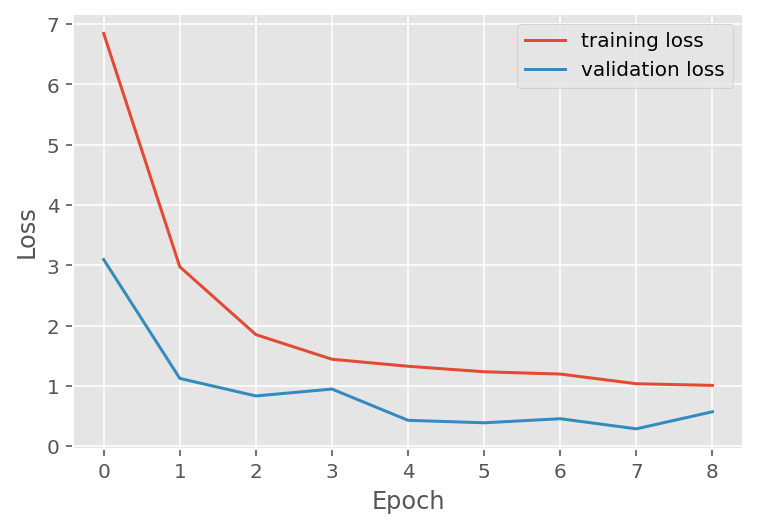

In [20]:
plt.style.use('ggplot')
plt.plot(TrainingLoss, label='training loss')
plt.plot(ValidationLoss, label='validation loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

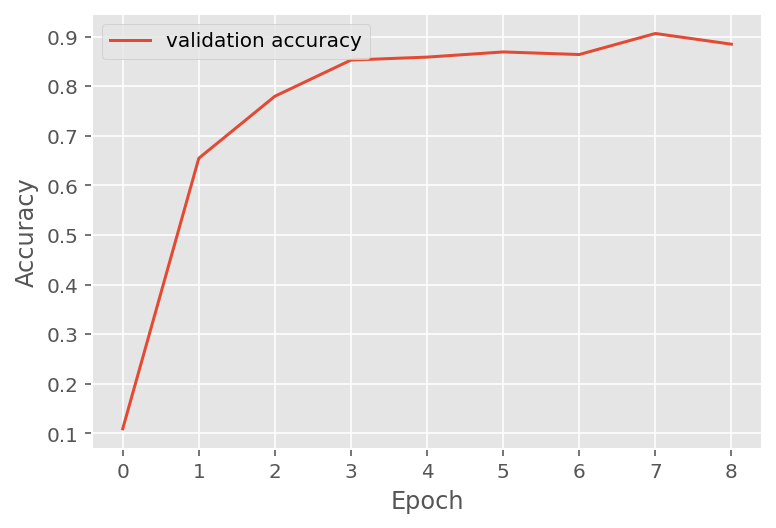

In [21]:
plt.style.use('ggplot')
plt.plot(ValidationAccuracy, label='validation accuracy')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

同时，我们可以将测试集代入模型，判断模型在测试集上的分类准确率。可以得到80%以上的准确率，证明模型的分类效果良好。

In [22]:
correct = 0
total = 0
# 将测试集代入模型进行分类
with torch.no_grad():
    for data in testloader:
        # 预测图像所属类别
        inputs, labels = data
        inputs, labels = inputs.to('cuda'), labels.to('cuda')
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        # 判断分类是否准确
        correct += (predicted == labels).sum().item()
        
print('模型在测试集上分类准确率: %d %%' % (100 * correct / total))

模型在测试集上分类准确率: 84 %


最后，我们抽取单张图像，直观展示模型的分类能力。首先定义展示测试图像的函数`show`。

In [23]:
# 定义函数展示图像
def show(img):
    plt.figure(figsize=(3, 3))
    img = img / 2 + 0.5   
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

将图像分为多个批次，每批次只包含一张图像，便于进行单张图像的测试。

In [24]:
oneloader = torch.utils.data.DataLoader(test_data,batch_size=1,shuffle=False)

将单张图像放入模型，观测模型的预测效果。可以看到下图中的神奇宝贝属于“三地鼠”类别，模型也将其预测为“三地鼠”。

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


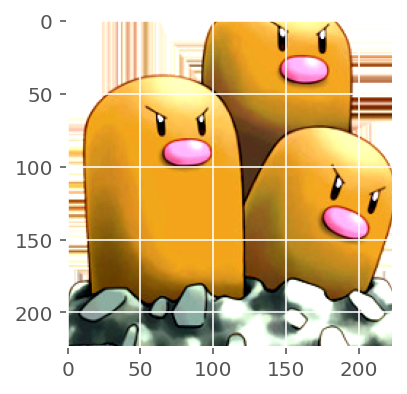

预测类别：  三地鼠
真实类别：  三地鼠


In [25]:
class_names = os.listdir("/content/Pokemon")
class_names.sort()
model.to ('cpu')
with torch.no_grad():
    for data in oneloader:
        inputs, labels = data
        inputs, labels = inputs.to("cpu"), labels.to("cpu")
        show(inputs[0])
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        print("预测类别： ",class_names[int(predicted[0])])
        print("真实类别： ",class_names[int(labels[0])])
        break

<div id="8"></div>
# 8 总结

本案例中，我们使用了预训练的VGG16模型，训练Pokemon数据集，实现图像分类。首先介绍了在得到原始数据集后，如何将其划分为训练集、测试集、测试集。并根据原始数据集，生成类别标签到名称的映射。之后构建VGG16模型，进行模型训练，在测试集上得到了87%的准确率。在进行一系列图像分类效果评估后，可以说明该模型的图像分类效果良好。